In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import prophet

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [102]:
train=pd.read_csv('Train.csv')
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [103]:
train['Datetime']=pd.to_datetime(train['Datetime'])

In [104]:
test=pd.read_csv('Test.csv')
test.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [105]:
test['Datetime']=pd.to_datetime(test['Datetime'])

In [140]:
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df['Datetime']
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(train, label='Count')

features_and_target = pd.concat([X, y], axis=1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_18248\97211920.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [107]:
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Count
0,0,5,3,8,2012,238,25,34,8
1,1,5,3,8,2012,238,25,34,2
2,2,5,3,8,2012,238,25,34,6
3,3,5,3,8,2012,238,25,34,2
4,4,5,3,8,2012,238,25,34,2
...,...,...,...,...,...,...,...,...,...
18283,19,3,3,9,2014,268,25,39,868
18284,20,3,3,9,2014,268,25,39,732
18285,21,3,3,9,2014,268,25,39,702
18286,22,3,3,9,2014,268,25,39,580


In [108]:
ID_train = train.ID
ID_test = test.ID

train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  18288 non-null  datetime64[ns]
 1   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 285.9 KB


In [110]:
train.index=pd.to_datetime(train.index)

In [111]:
split_date = '2014-06-25'
j_train = train.loc[train['Datetime'] <= split_date].copy()
j_val = train.loc[train['Datetime'] > split_date].copy()
j_test = test.copy()

In [112]:
train.index=train.index.astype(str)

In [113]:
j_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15625 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.000017831
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  15625 non-null  datetime64[ns]
 1   Count     15625 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 366.2 KB


In [114]:
j_val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2663 entries, 1970-01-01 00:00:00.000012 to 1970-01-01 00:00:00.000018287
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  2663 non-null   datetime64[ns]
 1   Count     2663 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 62.4 KB


In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  5112 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 40.1 KB


In [116]:
j_train.Timestamp = pd.to_datetime(j_train.Datetime,format='%d-%m-%Y %H:%M') 
j_train.index = j_train.Timestamp 
j_train = j_train.resample('D').mean() 
j_val.Timestamp = pd.to_datetime(j_val.Datetime,format='%d-%m-%Y %H:%M') 
j_val.index = j_val.Timestamp 
j_val = j_val.resample('D').mean()

C:\Users\Hp\AppData\Local\Temp\ipykernel_18248\1736177830.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  j_train.Timestamp = pd.to_datetime(j_train.Datetime,format='%d-%m-%Y %H:%M')
C:\Users\Hp\AppData\Local\Temp\ipykernel_18248\1736177830.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  j_train = j_train.resample('D').mean()
C:\Users\Hp\AppData\Local\Temp\ipykernel_18248\1736177830.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  j_val.Timestamp = pd.to_datetime(j_val.Datetime,format='%d-%m-%Y %H:%M')
C:\Users\Hp\AppData\Local\Temp\ipykernel_18248\173

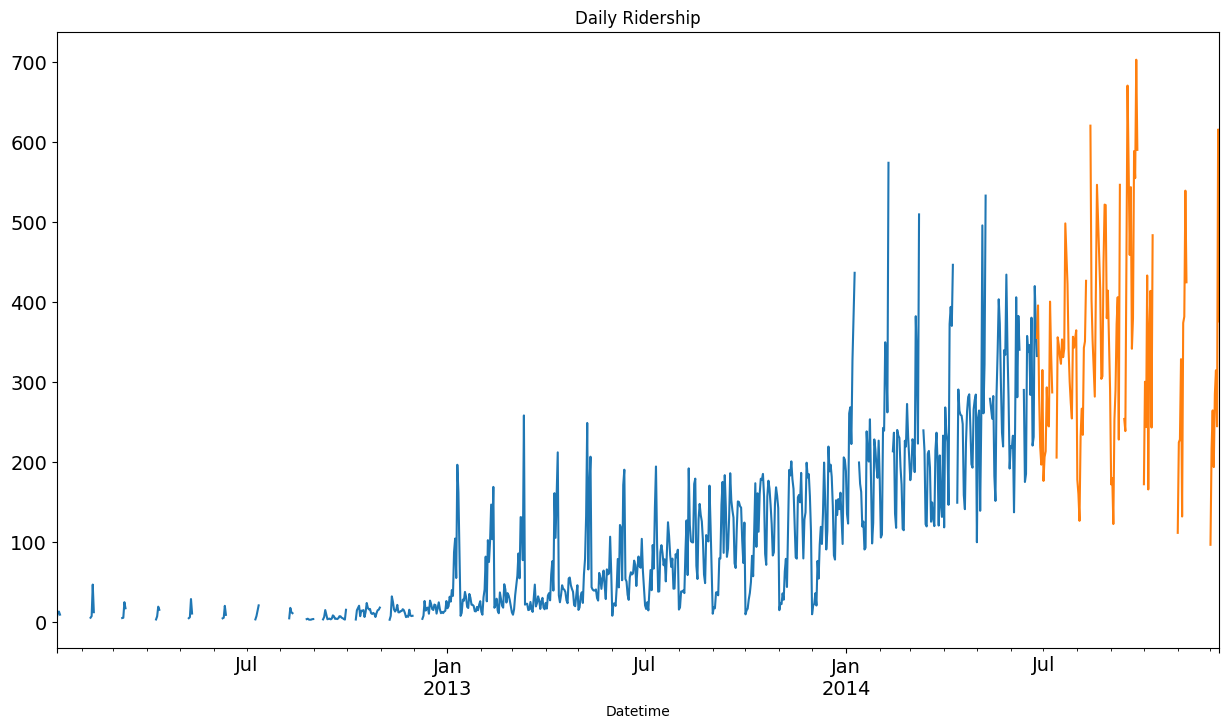

In [117]:
j_train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
j_val.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

In [118]:
j_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'Count':'y'})

,ds,y
0,2012-01-09,4.666667
1,2012-01-10,10.333333
2,2012-01-11,12.666667
3,2012-01-12,8.750000
4,2012-01-13,NaN
...,...,...
894,2014-06-21,220.083333
895,2014-06-22,230.833333
896,2014-06-23,419.416667
897,2014-06-24,372.166667


In [119]:
j_test.reset_index() \
    .rename(columns={'Datetime':'ds'})

,index,ds
0,0,2014-09-26 00:00:00
1,1,2014-09-26 01:00:00
2,2,2014-09-26 02:00:00
3,3,2014-09-26 03:00:00
4,4,2014-09-26 04:00:00
...,...,...
5107,5107,2015-04-26 19:00:00
5108,5108,2015-04-26 20:00:00
5109,5109,2015-04-26 21:00:00
5110,5110,2015-04-26 22:00:00


In [120]:
from prophet import Prophet

### Training a Prophet model ###

In [121]:
model = Prophet()
model.fit(j_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'Count':'y'}))

09:31:12 - cmdstanpy - INFO - Chain [1] start processing
09:31:13 - cmdstanpy - INFO - Chain [1] done processing


In [122]:
j_val_fcst = model.predict(df=j_val.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
j_val_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-06-25,283.750572,249.225750,381.695766,283.750572,283.750572,28.212367,28.212367,28.212367,8.388776,8.388776,8.388776,19.823591,19.823591,19.823591,0.0,0.0,0.0,311.962939
1,2014-06-26,284.385123,242.190330,386.987355,284.385123,284.385123,31.361585,31.361585,31.361585,11.076912,11.076912,11.076912,20.284673,20.284673,20.284673,0.0,0.0,0.0,315.746708
2,2014-06-27,285.019675,230.733213,379.574981,285.019675,285.019675,23.766401,23.766401,23.766401,3.363065,3.363065,3.363065,20.403336,20.403336,20.403336,0.0,0.0,0.0,308.786076
3,2014-06-28,285.654226,211.848653,354.151276,285.654226,285.654226,-3.362195,-3.362195,-3.362195,-23.525623,-23.525623,-23.525623,20.163429,20.163429,20.163429,0.0,0.0,0.0,282.292031
4,2014-06-29,286.288777,212.148801,362.619476,286.288777,286.288777,0.976201,0.976201,0.976201,-18.582043,-18.582043,-18.582043,19.558245,19.558245,19.558245,0.0,0.0,0.0,287.264978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2014-12-05,387.182411,277.447119,416.416630,380.308583,395.002027,-40.197801,-40.197801,-40.197801,3.363065,3.363065,3.363065,-43.560867,-43.560867,-43.560867,0.0,0.0,0.0,346.984610
164,2014-12-06,387.816962,253.553360,391.758825,380.880136,395.697711,-68.860638,-68.860638,-68.860638,-23.525623,-23.525623,-23.525623,-45.335015,-45.335015,-45.335015,0.0,0.0,0.0,318.956324
165,2014-12-07,388.451514,256.529882,393.937418,381.451689,396.393395,-65.304693,-65.304693,-65.304693,-18.582043,-18.582043,-18.582043,-46.722650,-46.722650,-46.722650,0.0,0.0,0.0,323.146820
166,2014-12-08,389.086065,276.240181,416.744128,382.023242,397.089079,-42.087090,-42.087090,-42.087090,5.588678,5.588678,5.588678,-47.675768,-47.675768,-47.675768,0.0,0.0,0.0,346.998975


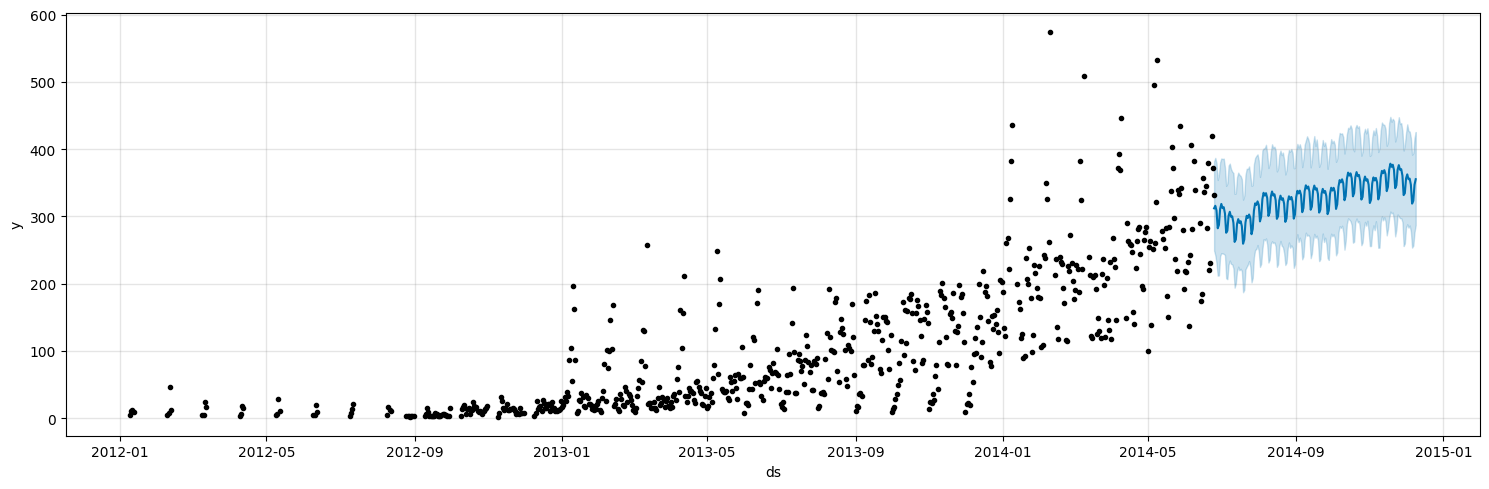

In [123]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(j_val_fcst,
                 ax=ax)
plt.show()

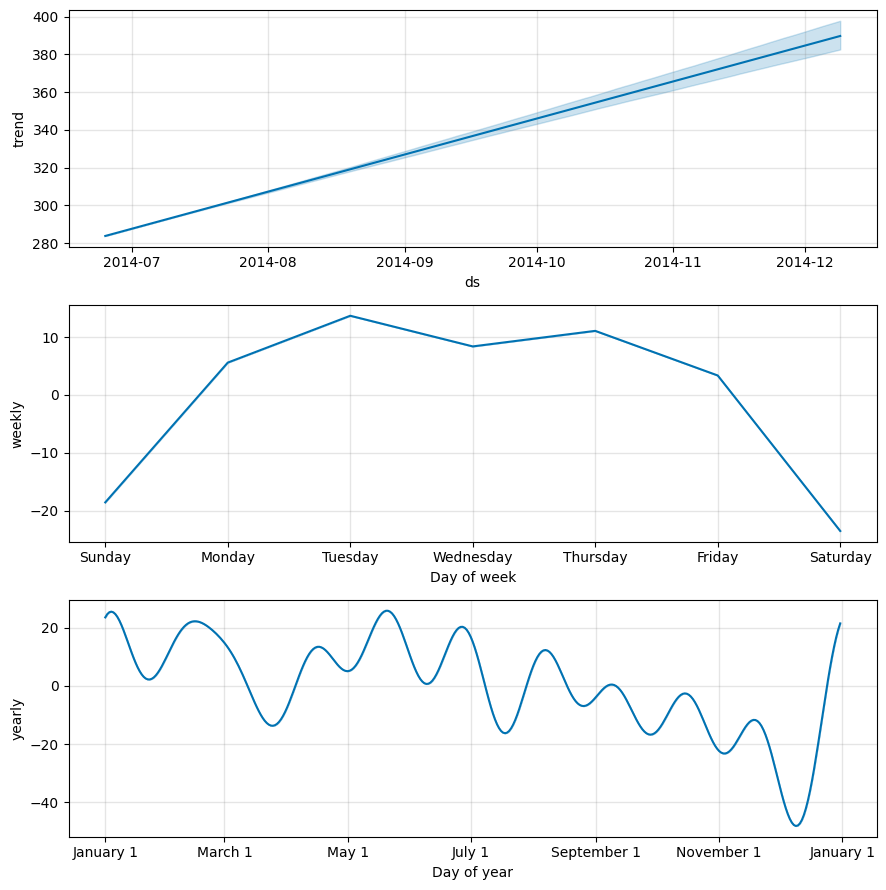

In [124]:
fig = model.plot_components(j_val_fcst)

### Forecast Vs Actuals ###

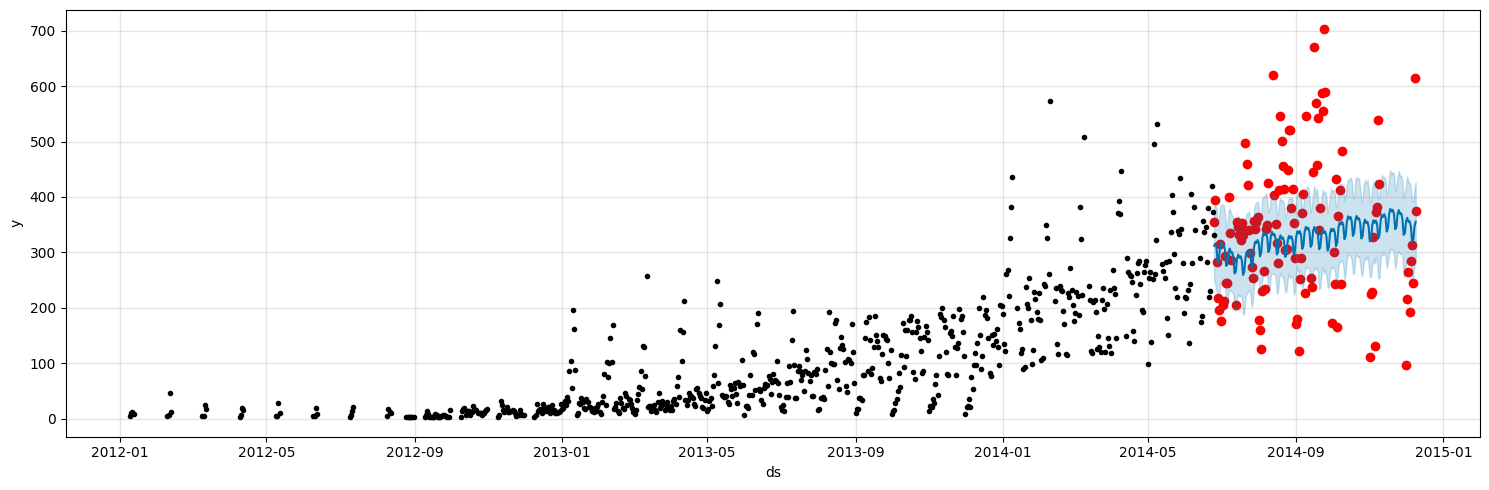

In [125]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(j_val.index, j_val['Count'], color='r')
fig = model.plot(j_val_fcst, ax=ax)


In [126]:
j_val.isna()

,Count
Datetime,
2014-06-25,False
2014-06-26,False
2014-06-27,False
2014-06-28,False
2014-06-29,False
...,...
2014-12-05,False
2014-12-06,False
2014-12-07,False


In [127]:
j_val_fcst.isna()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
164,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
165,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
166,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [128]:
j_val.fillna(0,inplace=True)

In [129]:
j_val_fcst.fillna(0,inplace=True)

In [130]:
mean_squared_error(y_true=j_val['Count'],
                   y_pred=j_val_fcst['yhat'])

51633.77950131197

In [131]:
mean_absolute_error(y_true=j_val['Count'],
                   y_pred=j_val_fcst['yhat'])

184.33789581354878

In [132]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=j_val['Count'],
                   y_pred=j_val_fcst['yhat'])

C:\Users\Hp\AppData\Local\Temp\ipykernel_18248\1027225969.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


inf

###  Issue 1 - Getting Inf as MAP. - What could be the reason for this? ###

In [133]:
y_true = j_val.Count.values
y_true

array([354.60869565, 395.25      , 282.33333333, 218.25      ,
       196.25      , 314.5       , 175.91666667, 205.75      ,
       212.91666667, 292.83333333, 245.66666667, 244.        ,
       400.        , 334.83333333, 286.5       ,   0.        ,
         0.        ,   0.        , 205.08333333, 355.41666667,
       345.91666667, 331.5       , 322.25      , 352.75      ,
       330.58333333, 341.        , 497.75      , 458.83333333,
       422.08333333, 339.83333333, 299.66666667, 273.41666667,
       253.91666667, 356.08333333, 342.41666667, 354.08333333,
       364.16666667, 177.41666667, 159.5       , 126.        ,
       231.08333333, 266.16666667, 233.5       , 342.25      ,
       350.25      , 426.        ,   0.        ,   0.        ,
         0.        , 619.91666667, 403.        , 351.33333333,
       317.66666667, 281.25      , 413.        , 546.        ,
       500.91666667, 456.33333333, 414.33333333, 303.41666667,
       306.66666667, 448.5       , 521.25      , 520.66

In [134]:
y_hat = j_val_fcst.yhat.astype(int)
y_hat

0      311
1      315
2      308
3      282
4      287
      ... 
163    346
164    318
165    323
166    346
167    355
Name: yhat, Length: 168, dtype: int32

In [135]:
y_pred=j_val_fcst['yhat']

In [136]:
dfval=pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
dfval.reset_index(drop=True, inplace=True)
dfval

,Actual,Predicted
0,354.608696,311.962939
1,395.250000,315.746708
2,282.333333,308.786076
3,218.250000,282.292031
4,196.250000,287.264978
...,...,...
163,284.416667,346.984610
164,314.166667,318.956324
165,244.083333,323.146820
166,615.083333,346.998975


In [137]:
j_test_fcst = model.predict(df=j_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
j_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-10 00:00:00,178.415080,135.893059,272.776284,178.415080,178.415080,23.054836,23.054836,23.054836,3.363065,3.363065,3.363065,19.691770,19.691770,19.691770,0.0,0.0,0.0,201.469916
1,2014-01-10 01:00:00,178.441520,132.074046,270.602928,178.441520,178.441520,21.955112,21.955112,21.955112,2.336994,2.336994,2.336994,19.618118,19.618118,19.618118,0.0,0.0,0.0,200.396632
2,2014-01-10 02:00:00,178.467959,125.399056,269.024182,178.467959,178.467959,20.808772,20.808772,20.808772,1.264565,1.264565,1.264565,19.544207,19.544207,19.544207,0.0,0.0,0.0,199.276731
3,2014-01-10 03:00:00,178.494399,128.064242,268.533033,178.494399,178.494399,19.619871,19.619871,19.619871,0.149831,0.149831,0.149831,19.470040,19.470040,19.470040,0.0,0.0,0.0,198.114270
4,2014-01-10 04:00:00,178.520839,130.628384,262.560962,178.520839,178.520839,18.392828,18.392828,18.392828,-1.002794,-1.002794,-1.002794,19.395622,19.395622,19.395622,0.0,0.0,0.0,196.913667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,2015-12-04 19:00:00,618.661386,472.686782,643.515653,580.030389,659.580188,-61.764551,-61.764551,-61.764551,-19.131106,-19.131106,-19.131106,-42.633445,-42.633445,-42.633445,0.0,0.0,0.0,556.896835
5108,2015-12-04 20:00:00,618.687826,472.620107,634.513217,580.044335,659.608766,-62.852720,-62.852720,-62.852720,-20.132235,-20.132235,-20.132235,-42.720485,-42.720485,-42.720485,0.0,0.0,0.0,555.835106
5109,2015-12-04 21:00:00,618.714266,471.164682,634.661180,580.059701,659.650268,-63.883499,-63.883499,-63.883499,-21.076507,-21.076507,-21.076507,-42.806992,-42.806992,-42.806992,0.0,0.0,0.0,554.830766
5110,2015-12-04 22:00:00,618.740705,470.052456,632.720703,580.075067,659.708777,-64.852449,-64.852449,-64.852449,-21.959487,-21.959487,-21.959487,-42.892962,-42.892962,-42.892962,0.0,0.0,0.0,553.888256


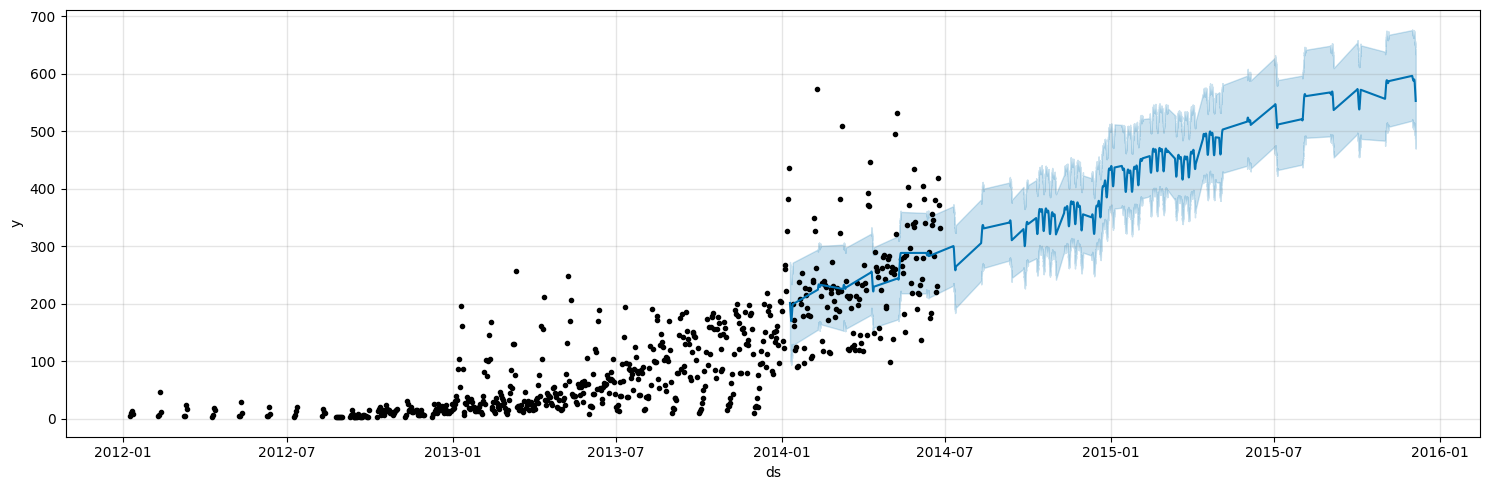

In [138]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(j_test_fcst,
                 ax=ax)
plt.show()

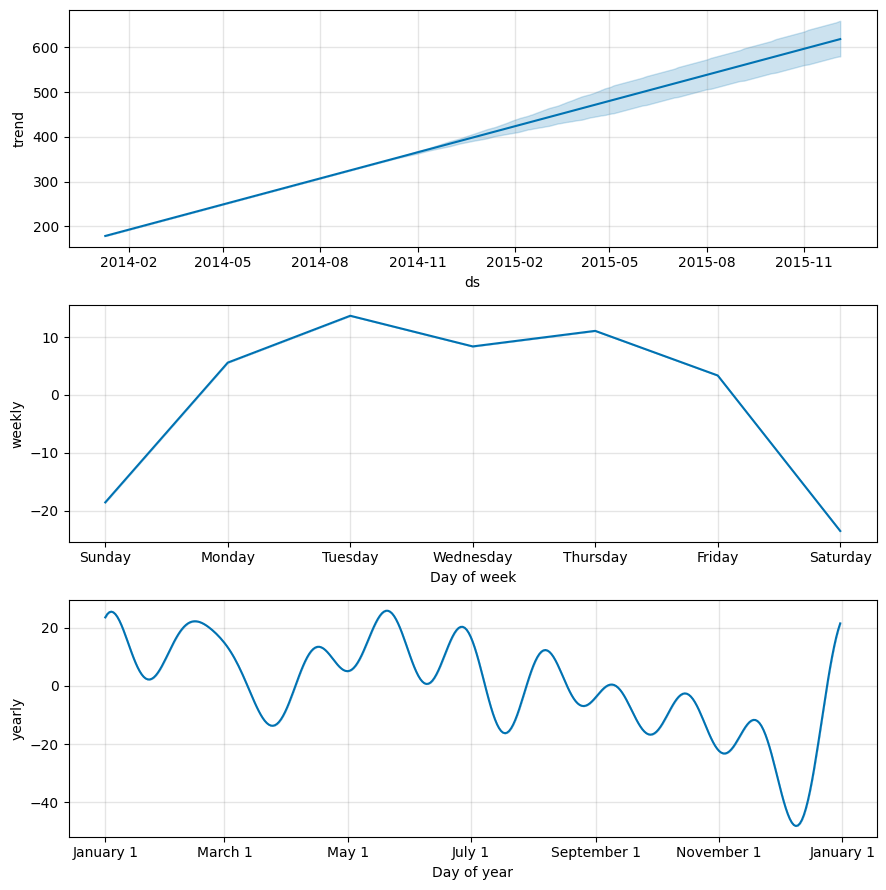

In [139]:
fig = model.plot_components(j_test_fcst)